### Comparison of the effect of using different optimizers (ReLU) (1/2) - Sequential

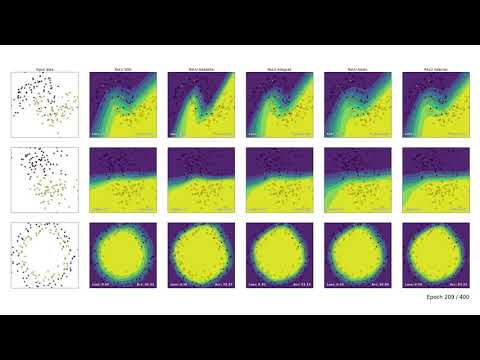

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('TEBX0zaviRE', width=960, height=540)

### Comparison of the effect of using different optimizers (ReLU) (1/2) - Batches of 32

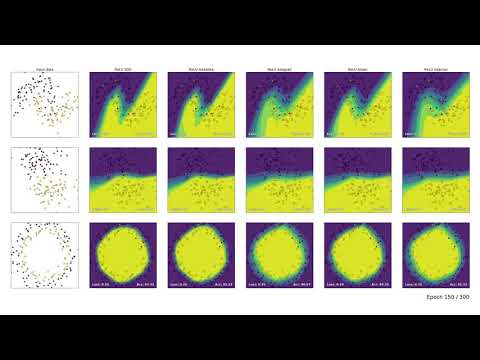

In [2]:
YouTubeVideo('Ikd1VOeerUY', width=960, height=540)

### Imports & setup

In [ ]:
# Refer to the parent path:
import sys
sys.path.append('../')

# Import the helper scripts:
from utils import *

# Name of the experiment:
name="optimizers_relu1"

%matplotlib inline

### Generate a two moons dataset

In [ ]:
X_moons, y_moons = sklearn.datasets.make_moons(150, noise=0.25, random_state=0)
y_moons = np.where(y_moons==0, -1., y_moons)
plt.scatter(X_moons[:,0], X_moons[:,1], s=40, c=y_moons)

### Generate a two blobs dataset

In [ ]:
X_blobs, y_blobs = sklearn.datasets.make_blobs(n_samples=150, centers=2, n_features=2, random_state=0)
y_blobs = np.where(y_blobs==0, -1., y_blobs)
plt.scatter(X_blobs[:,0], X_blobs[:,1], s=40, c=y_blobs)

### Generate a concentric circles dataset

In [ ]:
X_circles, y_circles = sklearn.datasets.make_circles(n_samples=150, noise=0.09, random_state=0)
y_circles = np.where(y_circles==0, -1., y_circles)
plt.scatter(X_circles[:,0], X_circles[:,1], s=40, c=y_circles)

### Convert SKLearn datasets into PyTorch datasets

In [ ]:
moons_dataset = convert_to_pytorch_dataset(X_moons, y_moons)
blobs_dataset = convert_to_pytorch_dataset(X_blobs, y_blobs)
circles_dataset = convert_to_pytorch_dataset(X_circles, y_circles)

datasets = [moons_dataset, blobs_dataset, circles_dataset]

### Create classifier models

In [ ]:
# A Rectified Linear Unit (ReLU) based neural network:
class ReLUNet(nn.Module):
    def __init__(self, input_size):
        super(ReLUNet, self).__init__()
        self.layers = nn.Sequential(nn.Flatten(),
                                    nn.Linear(input_size, 32),
                                    nn.ReLU(),
                                    nn.Linear(32, 32),
                                    nn.ReLU(),
                                    nn.Linear(32, 1))

    def forward(self, x):
        return torch.erf(self.layers(x))

# Selected models are initialized for every dataset:
models = [{
    'ReLU SGD': ReLUNet(2),
    'ReLU Adadelta': ReLUNet(2),
    'ReLU Adagrad': ReLUNet(2),
    'ReLU Adam': ReLUNet(2),
    'ReLU Adamax': ReLUNet(2)
          } for _ in datasets]

# Initialise all networks with the same weights and biases:
state = next(iter(models[0].values())).state_dict()
for d, _ in enumerate(datasets):
    for m in models[d].values():
        m.load_state_dict(state)

### Select the learning parameters

In [ ]:
wd = 0.001   # Weight decay

def make_optimizer(k, model):
    optimizer = {
        'ReLU SGD': torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=wd),
        'ReLU Adadelta': torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=wd),
        'ReLU Adagrad': torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=wd, initial_accumulator_value=0, eps=1e-10),
        'ReLU Adam': torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=wd, amsgrad=False),
        'ReLU Adamax': torch.optim.Adamax(model.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=wd)
    }
    return optimizer[k]

optimizers = [dict((k, make_optimizer(k, model)) for k, model in models[i].items()) for i in range(len(datasets))]

# Loss function:
criterion = nn.MSELoss()

# Number of epochs:
epochs = 300

# Sampling method:
batch_size=32
shuffle=True

### Generates the animated plot

In [ ]:
generate_animated_plot(epochs=epochs, 
                       datasets=datasets, 
                       models=models, 
                       optimizers=optimizers, 
                       criterion=criterion, 
                       filename=name, 
                       batch_size=batch_size, 
                       shuffle=shuffle)

### Make a video from the animated gif

In [ ]:
# Requires ffmpeg: sudo apt-get install ffmpeg

convert_to_video(filename=name, overwrite=True)

### Compress the generated gif (optional)

In [ ]:
# Requires gifsicle: sudo apt-get install gifsicle

compress_gif(filename=name, scale=0.7)